# Vectorization and Topic Analysis

In this notebook, we build a custom vectorizer to handle our processed and tokenized data. We then use decomposition techniques (Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), and non-Negative Matrix Factorization (NMF)) to generate topics for each corpus.

## Import the modules and data

In [1]:
import pandas as pd
import numpy as np
import spacy
import textacy
import pickle
import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD, IncrementalPCA

In [2]:
with open('../data/tokenized_rest_reviews.pkl', 'rb') as f:
    rests = pickle.load(f)

In [2]:
with open('../data/tokenized_bs_reviews.pkl', 'rb') as bus:
    bus = pickle.load(bus)

## Build the custom tf-idf vectorizer

Since I used spacy to tokenize the restaurant reviews, I can't use the default tf-idf vectorizer from sklearn since by default the tf-idf vectorizer incorporates 3 steps: analyzer, tokenizer, and preprocessor. I will need to construct a custom vectorizer using the tf-idf framework that takes into account that we have already processed and tokenized our text data. We use the `identity` function to tell the vectorizer to not modify the text in the tokenizer and preprocessor stages.


In [3]:
def identity(doc):
    return doc

In [4]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=identity, preprocessor=identity, token_pattern=None, 
                             strip_accents='ascii', min_df=5, max_df=0.95, max_features=10000, use_idf=True,
                             sublinear_tf=True)

## Create document-term matrices for the two review corpora

### Restaurants

In [ ]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in rests))

### Businesses

In [5]:
doc_term_matrix = vectorizer.fit_transform((doc for doc in bus))

## Create topic models and print out topics

I compared the topic generation of three decomposition models: Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) (also known as Truncated SVD), and non-Negative Matrix Factorization (NMF) on the restaurant review dataset. Research (**Blei et. al (2003)** http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf, **Stevens et. al (2012)** http://aclweb.org/anthology/D/D12/D12-1087.pdf) suggests that the most important characteristic of topics used in text classification to improve accuracy is the *quality* of topics; thus we should choose the topic modeling that gives the most topics relevant to the review space.

After evaluation, I determined that LSA would be the best topic modeling algorithm for my current analyses. While both NMF and LSA could be fit on an AWS t2.2xlarge instance (32GB RAM), topics generated by NMF are heavily weighted toward the primary term; while those topics are very coherent they essentially only epxlain the presence of a single term in a documents. LSA was chosen due to its fast fit time and potential for expansion (as we achieved only 35% of explained variance with 350 topics). LDA was not performed due to a very long anticpated fit time, but will be done in a future update.

The two below functions will be used to visually inspect topics and the top documents in each corpus for the topics created by our models.

In [6]:
def print_topics(model):
    for topic_idx, top_terms in model.top_topic_terms(vectorizer.get_feature_names()):
        print('topic', topic_idx, ':', '   '.join(top_terms))

In [7]:
def top_topic_docs(corpus, model, doc_topic_matrix, n_topics):
    for topic_idx, top_docs in model.top_topic_docs(doc_topic_matrix, topics=n_topics, top_n=1):
        print(topic_idx)
        for j in top_docs:
            print(corpus[j])

### LSA - Restaurants

In [9]:
%%time
lsa_model = textacy.TopicModel('lsa', n_topics=200, n_jobs=-1)
lsa_model.fit(doc_term_matrix)

lsa_doc_topic_matrix = lsa_model.transform(doc_term_matrix)

CPU times: user 6min 37s, sys: 1min 4s, total: 7min 42s
Wall time: 4min 24s


/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


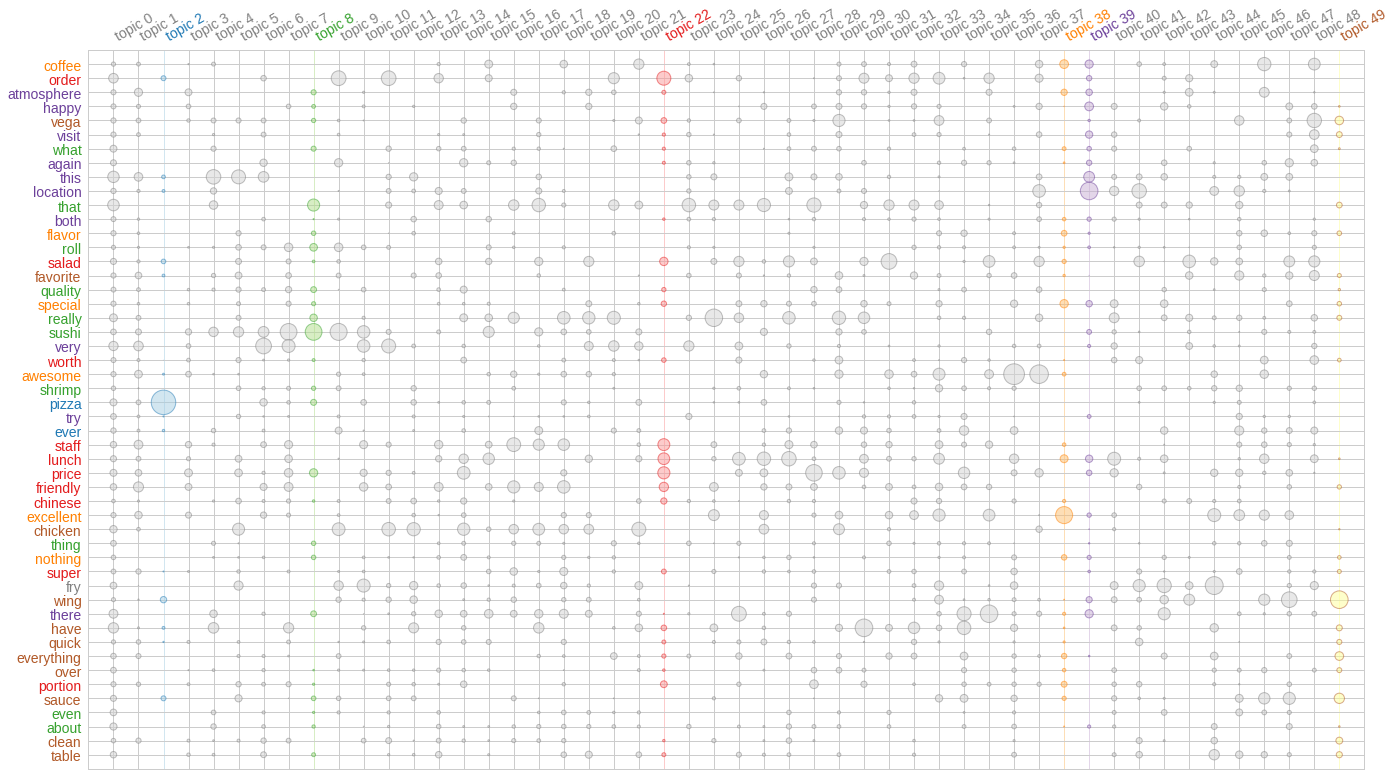

In [33]:
plt.figure(figsize=(50, 35))
lsa_model.termite_plot(doc_term_matrix,
                       vectorizer.get_feature_names(), 
                       topics=[num for num in range(0,50, 1)],
                       n_terms=50, 
                       highlight_topics=[2, 8, 22, 38, 39, 49])
plt.savefig('../visuals/lsa_termite.png')

In [25]:
print_topics(lsa_model)

topic 0 : numb   be   that   this   they   with   place   have   great   order
topic 1 : great   place   service   friendly   very   amaze   always   staff   this   delicious
topic 2 : pizza   crust   slice   wing   cheese   topping   delivery   pepperoni   sauce   order
topic 3 : numb   great   service   minute   price   atmosphere   friendly   star   staff   sushi
topic 4 : place   this   have   they   always   sushi   that   there   never   when
topic 5 : place   this   numb   chicken   sushi   fry   price   fresh   sandwich   sauce
topic 6 : very   sushi   this   back   place   restaurant   will   be   definitely   pizza
topic 7 : sushi   they   very   always   their   have   fresh   friendly   price   roll
topic 8 : sushi   great   that   much   with   price   roll   buffet   really   well
topic 9 : sushi   order   chicken   here   back   will   service   always   fry   amaze
topic 10 : burger   fry   very   sushi   burgers   friendly   they   staff   be   price
topic 11 : order  

For further analyses, we will be using the topics generated by Latent Semantic Analysis to bolster our classification models. We see that while LSA generates many 

In [30]:
top_topic_docs(rests, lsa_model, lsa_doc_topic_matrix, topics=list(range(0, 21)))

0
['this', 'place', 'terrible', 'girlfriend', 'be', 'search', 'something', 'unique', 'stumble', 'upon', 'melt', 'last', 'night', 'have', 'never', 'fondue', 'hear', 'story', 'much', 'that', 'experience', 'that', 'everyone', 'should', 'sunday', 'night', 'expect', 'which', 'when', '\ufeff1', 'walk', 'hostess', 'very', 'polite', 'understand', 'they', 'decide', 'take', 'down', 'phone', 'numb', 'just', 'them', 'there', 'be', 'maybe', 'numb', 'numb', 'other', 'table', 'people', 'they', 'seat', 'back', 'restaurant', 'which', 'pretty', 'disrespectful', 'opinion', 'hostess', 'explain', 'work', 'drink', 'order', 'after', 'about', 'numb', 'minute', 'sit', 'there', 'still', 'drink', 'finally', 'server', 'ask', 'what', 'want', 'drink', 'polite', 'good', 'much', 'depth', 'suggest', 'that', 'order', 'numb', 'course', 'meal', 'after', 'another', 'numb', 'numb', 'minute', 'finally', 'glass', 'water', 'drink', 'be', 'sit', 'there', 'about', 'numb', 'numb', 'minute', 'without', 'even', 'water', 'sit', 'th

In [34]:
np.save('../data/lsa_matrix.npy', lsa_doc_topic_matrix)

### LSA - Businesses

In [8]:
%%time
lsa_model_bs = TruncatedSVD(n_components=325, random_state=1)
lsa_model_bs.fit(doc_term_matrix)

CPU times: user 12min 14s, sys: 2min 32s, total: 14min 47s
Wall time: 7min 44s


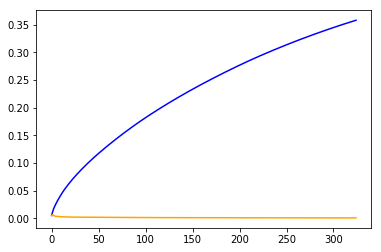

In [18]:
plt.plot(range(325), np.cumsum(lsa_model_bs.explained_variance_ratio_), color='blue', label='Cumulative % variance')
plt.plot(range(325), lsa_model_bs.explained_variance_ratio_, color='orange', label='% variance explained')

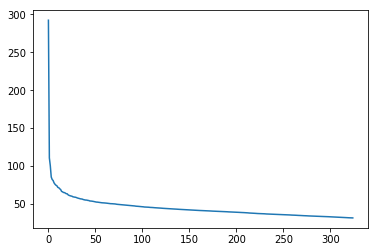

In [11]:
plt.plot(range(325), lsa_model_bs.singular_values_)

We can see that the amount of cumulative explained variance continuously increases as we add topics; however, due to memory limitations I have chosen to restrict the model to 350 components which explain 35% of total variance. While this loss is regrettable, we will only be using the topics to supplement other features in our classification models and thus regain some of the lost information.

In [20]:
lsa_model_bs = textacy.TopicModel('lsa', n_topics=325, random_state=1)
lsa_model_bs.fit(doc_term_matrix)
lsa_dt_matrix_bs = lsa_model_bs.transform(doc_term_matrix)

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:877: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


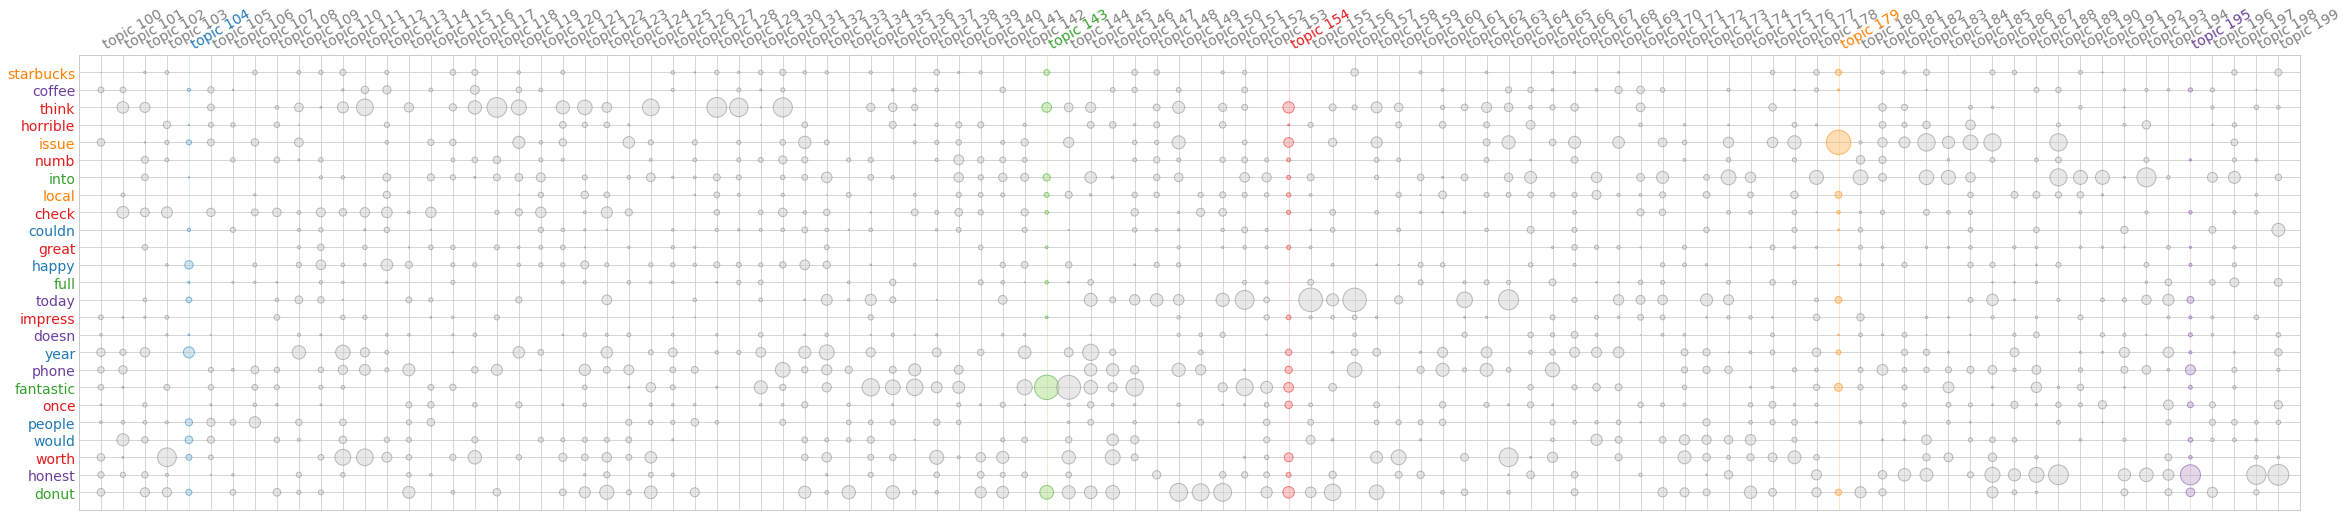

In [28]:
lsa_model_bs.termite_plot(doc_term_matrix, 
                          vectorizer.get_feature_names(), 
                          n_terms=25,
                          highlight_topics=[104, 143, 154, 179, 195],
                          topics=[num for num in range(100, 200)])

In [22]:
print_topics(lsa_model_bs)

topic 0 : they   numb   this   that   have   be   with   great   very   place
topic 1 : great   very   friendly   staff   recommend   highly   always   service   place   amaze
topic 2 : service   call   recommend   them   customer   company   highly   professional   would   thank
topic 3 : service   customer   store   they   price   always   great   their   selection   location
topic 4 : service   great   hotel   numb   vega   customer   night   stay   room   strip
topic 5 : staff   very   friendly   helpful   clean   hotel   store   room   location   office
topic 6 : numb   here   nail   staff   friendly   always   clean   back   salon   place
topic 7 : recommend   place   they   highly   numb   this   them   would   company   have
topic 8 : always   great   have   year   be   with   show   every   vega   here
topic 9 : great   price   numb   they   nail   selection   reasonable   them   very   do
topic 10 : great   staff   place   call   office   friendly   doctor   this   make   dri

topic 177 : another   such   beyond   shop   issue   above   wrong   absolutely   color   worth
topic 178 : such   park   extremely   different   into   color   month   another   wait   then
topic 179 : issue   same   cheap   stuff   small   minute   another   extremely   cupcake   night
topic 180 : beyond   above   into   another   atmosphere   disappoint   where   last   product   something
topic 181 : treat   cheap   absolutely   shop   house   bring   color   sweet   another   cupcake
topic 182 : atmosphere   color   shop   keep   comfortable   another   month   front   knowledgeable   than
topic 183 : issue   airport   into   buy   fresh   flavor   shop   want   honest   such
topic 184 : where   reasonable   anyone   into   color   extremely   issue   night   start   perfect
topic 185 : absolutely   where   buy   issue   stuff   park   favorite   treat   dentist   offer
topic 186 : front   issue   comfortable   honest   park   through   want   than   different   patient
topic 187 

In [29]:
np.save('../data/business_doc_topic_matrix.npy', lsa_dt_matrix_bs)

### NMF

In [22]:
%%time
nmf_model = textacy.TopicModel('nmf', n_topics=50, n_jobs=-1)
nmf_model.fit(doc_term_matrix)

CPU times: user 1h 29min 46s, sys: 3min 6s, total: 1h 32min 53s
Wall time: 1h 28min 27s


In [23]:
doc_topic_matrix_nmf = nmf_model.transform(doc_term_matrix)

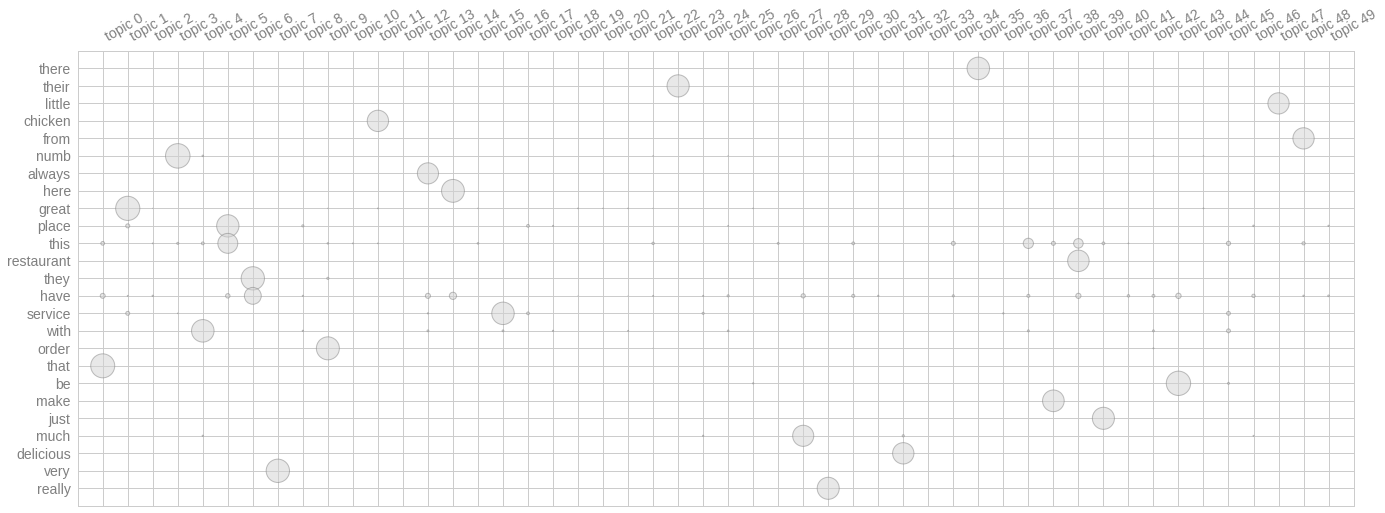

In [25]:
nmf_model.termite_plot(doc_term_matrix, vectorizer.get_feature_names(), topics=[num for num in range(0, 50, 1)])

In [ ]:
topics_and_top_docs(nmf_model, doc_topic_matrix_nmf, topics=[num for num in range(0, 25, 1)])

topic 0 : be   both   table   server   seat   time   disappoint   since   which   experience
topic 1 : great   atmosphere   price   selection   place   happy   fantastic   patio   music   service
topic 2 : pizza   crust   slice   cheese   wing   topping   pepperoni   delivery   sauce   italian
topic 3 : numb   minute   star   only   about   wait   give   after   people   hour
topic 4 : with   sauce   which   cheese   friend   side   some   also   flavor   sweet
topic 5 : place   this   look   about   from   favorite   review   location   find   vega
topic 6 : they   them   make   also   when   close   because   serve   offer   give
topic 7 : very   tasty   attentive   clean   good   also   portion   reasonable   small   price
topic 8 : sushi   roll   sashimi   salmon   quality   japanese   tempura   spicy   nigiri   happy
topic 9 : order   minute   take   when   wait   after   ask   wrong   call   then
topic 10 : burger   fry   burgers   cheese   onion   shake   bacon   patty   ring   

In [27]:
with open('../data/nmf_doctopic_matrix.pkl', 'wb') as f:
    pickle.dump(doc_topic_matrix_nmf, f)